In [1]:
import torch

# GPU 사용 가능 -> True, GPU 사용 불가 -> False
print(torch.cuda.is_available())

True


In [2]:
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from datasets import Dataset
from sklearn.model_selection import train_test_split

C:\Users\hoong\anaconda3\envs\teampro\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the dataset
dataset_url = 'kmhas_dataset.txt'
data = pd.read_csv(dataset_url, sep='\t')

In [4]:
# Merge labels
label_columns = ['출신차별', '외모차별', '정치성향차별', '혐오욕설', '연령차별', '성차별', '인종차별', '종교차별', '해당사항 없음']
data['multi_class_label'] = data[label_columns].idxmax(axis=1)

In [5]:
# Encode Label & Make label column
id2label = {k:v for k, v in enumerate(data['multi_class_label'].unique())}
label2id = {v:k for k, v in id2label.items()}

data['labels'] = data['multi_class_label'].map(label2id)

In [6]:
# Split and Make Dataset
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

train_dataset = Dataset.from_dict(train_data)
val_dataset = Dataset.from_dict(val_data)
test_dataset = Dataset.from_dict(test_data)

In [7]:
# Tokenize Dataset
tokenizer = AutoTokenizer.from_pretrained('snunlp/KR-BERT-char16424')
def tokenize_data(data):
    encoded = tokenizer(
        data['document'],
        truncation=True
    )
    encoded['labels'] = data['labels']
    return encoded

tokenized_train_dataset = train_dataset.map(tokenize_data, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_data, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_data, batched=True)

Map: 100%|█████████████████████████████████████████████████████████████| 10970/10970 [00:00<00:00, 36202.60 examples/s]


In [8]:
# Load Collator
collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest'    # pad to longest sequence in batch
)

In [9]:
# Function to compute metrics
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    accuracy = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

In [10]:
# Load arguments
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        weight_decay=.01,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=3e-5,
        evaluation_strategy='steps',
        eval_steps=300,
        save_strategy='steps',
        save_steps=300,
        logging_strategy='steps',
        logging_steps=500,
        save_total_limit=1,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        lr_scheduler_type='cosine',
        warmup_ratio=0.1,
        no_cuda=False
        
    )

C:\Users\hoong\anaconda3\envs\teampro\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Load & Train model

model = AutoModelForSequenceClassification.from_pretrained('snunlp/KR-BERT-char16424', id2label=id2label, label2id=label2id)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at snunlp/KR-BERT-char16424 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\hoong\anaconda3\envs\teampro\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss,Accuracy,F1
300,No log,1.421122,0.542164,0.387853
600,1.567700,1.077805,0.653660,0.579817
900,1.567700,0.750907,0.747926,0.745073
1200,0.927100,0.643419,0.783845,0.781271
1500,0.700500,0.604973,0.799344,0.791792
1800,0.700500,0.588735,0.801714,0.794763
2100,0.611800,0.566720,0.800164,0.801498
2400,0.611800,0.543881,0.814112,0.809433
2700,0.590200,0.520287,0.820768,0.816635
3000,0.544400,0.542648,0.818762,0.813656


TrainOutput(global_step=16455, training_loss=0.41247275812362905, metrics={'train_runtime': 5833.2672, 'train_samples_per_second': 45.131, 'train_steps_per_second': 2.821, 'total_flos': 9246233687364432.0, 'train_loss': 0.41247275812362905, 'epoch': 3.0})

In [12]:
# Evaluate the final model on the test set
test_results = trainer.evaluate(tokenized_test_dataset)

print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

Test Accuracy: 0.8548769371011851
Test F1 Score: 0.8544621206129359


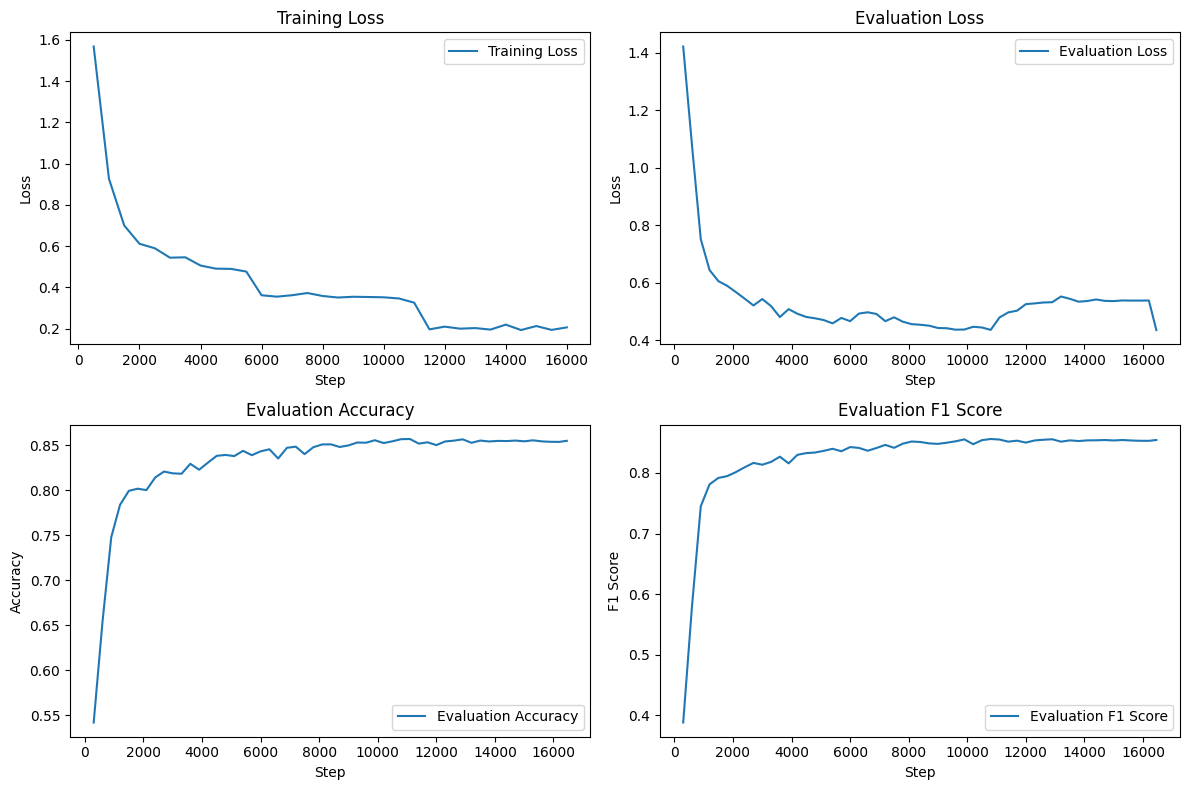

In [14]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Creating the plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(eval_steps, eval_loss, label='Evaluation Loss')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(eval_steps, eval_accuracy, label='Evaluation Accuracy')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(eval_steps, eval_f1, label='Evaluation F1 Score')  # Use eval_steps here
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Evaluation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

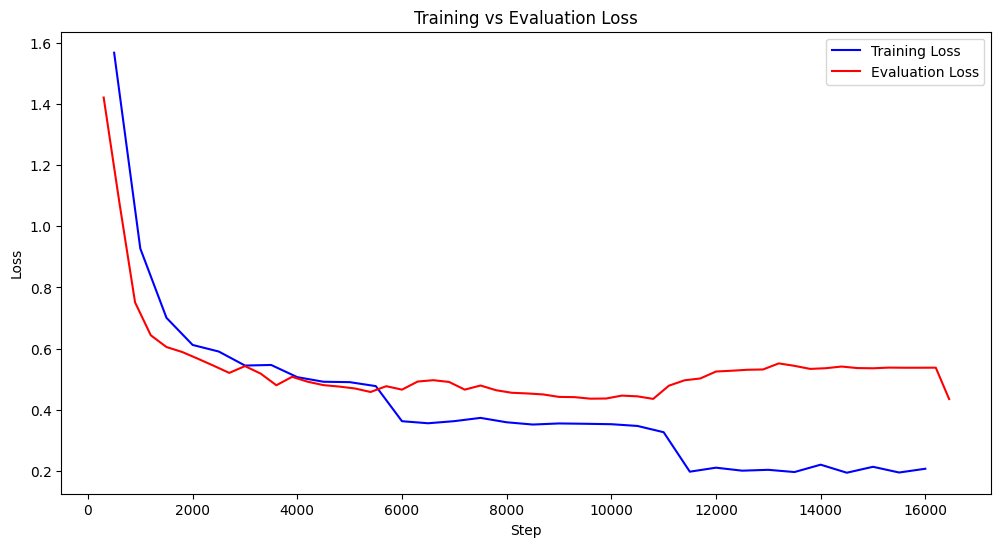

In [15]:
import matplotlib.pyplot as plt

# Fetching metrics from the trainer's logs
log_history = trainer.state.log_history

# Extracting values for plotting
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

for entry in log_history:
    if 'loss' in entry and 'step' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    elif 'eval_loss' in entry:
        eval_steps.append(entry['step'])  # Ensure steps are logged with eval metrics
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])
        eval_f1.append(entry['eval_f1'])

# Plotting Loss (Training and Evaluation on the same graph)
plt.figure(figsize=(12, 6))

plt.plot(train_steps, train_loss, label='Training Loss', color='blue')
plt.plot(eval_steps, eval_loss, label='Evaluation Loss', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training vs Evaluation Loss')
plt.legend()
